# LSTM Neural Network for Bitcoin

An LSTM (Long Short-Term Memory) neural network is a powerful deep learning model designed to handle time series data, making it an excellent choice for forecasting financial markets, including stock prices and cryptocurrencies.

LSTMs are particularly useful because they can capture long-term dependencies and patterns in data, overcoming the vanishing gradient problem commonly faced by traditional recurrent neural networks (RNNs). By using an LSTM model, investors can uncover hidden relationships and trends in historical data, which can then be utilized to make more informed trading decisions.

The model's performance can be evaluated using various metrics, such as the Mean Absolute Percentage Error (MAPE), which quantifies the average magnitude of errors between predicted and actual values.

This project showcases the efficacy of LSTMs combine with cross-validation in predicting the price of Bitcoin. The model will be trained and tested on data from the past 364 days and will require a free API key from the following website: https://www.cryptocompare.com/

##### We first need to import the necessary libraries for data analysis.

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import talib
import requests
import requests
import csv
import json

## Retrieving the Data

##### Let's fetch the data from CryptoCompare's API.

In [2]:
api_key = 'your_api_key'

In [ ]:
def fetch_historical_data():
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 364,
        'toTs': int(pd.Timestamp.utcnow().timestamp()),
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    json_data = response.json()
    print(json_data)  # Print json_data to debug

    historical_data = json_data['Data']['Data']
    df = pd.DataFrame(historical_data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return df

# Test the function
df = fetch_historical_data()
df.head()

In [4]:
df.tail()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
360,2023-03-27,28044.15,26565.75,27996.81,48705.37,1.332455e+09,27145.09,direct,
361,2023-03-28,27501.44,26660.19,27145.09,38686.66,1.046551e+09,27274.90,direct,
362,2023-03-29,28640.99,27261.75,27274.90,52216.18,1.471076e+09,28355.87,direct,
363,2023-03-30,29172.90,27731.64,28355.87,63033.78,1.790022e+09,28037.46,direct,
364,2023-03-31,28373.44,27926.47,28037.46,5850.41,1.649953e+08,28121.81,direct,


##### Now let's preprocess the data and add the necessary features for analysis.

In [5]:
# Technical Indicators
df['SMA'] = talib.SMA(df['close'], timeperiod=14)  # Simple Moving Average (14 days)
df['EMA'] = talib.EMA(df['close'], timeperiod=14)  # Exponential Moving Average (14 days)
df['RSI'] = talib.RSI(df['close'], timeperiod=14)  # Relative Strength Index (14 days)
df['MACD'], df['MACD_signal'], _ = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # Moving Average Convergence Divergence
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['close'], timeperiod=20)  # Bollinger Bands (20 days)
df['ATR'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)  # Average True Range (14 days)
df['%K'], df['%D'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3, slowd_period=3)  # Stochastic Oscillator
df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)  # Commodity Channel Index (14 days)
df['OBV'] = talib.OBV(df['close'], df['volumeto'])  # On Balance Volume
df['ROC'] = talib.ROC(df['close'], timeperiod=10)  # Rate of Change (10 days)
df['PSAR'] = talib.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)  # Parabolic Stop and Reverse

# Calculate VWAP
typical_price = (df['high'] + df['low'] + df['close']) / 3
cumulative_typical_price_volume = (typical_price * df['volumeto']).cumsum()
cumulative_volume = df['volumeto'].cumsum()

df['VWAP'] = cumulative_typical_price_volume / cumulative_volume


# Price-derived features
df['daily_return'] = df['close'].pct_change()  # Daily return
df['log_return'] = np.log(df['close'] / df['close'].shift(1))  # Log return

# Time-based features
df['day_of_week'] = df['time'].dt.dayofweek  # Day of the week (0: Monday, 1: Tuesday, ..., 6: Sunday)


# Drop missing values
df.dropna(inplace=True)

# Select only the columns that you want to use as features
feature_columns = ['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 
                   'BB_upper', 'BB_middle', 'BB_lower', 'daily_return', 'log_return', 
                   'day_of_week', 'ATR', '%K', 'CCI', 'OBV', 'ROC', 'PSAR', 'VWAP']
numerical_data = df[feature_columns]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Create a new DataFrame with scaled data
scaled_data = pd.DataFrame(scaled_numerical_data, columns=numerical_data.columns, index=numerical_data.index)

# Split the data into training and testing sets
train_data, test_data = scaled_data[:int(len(df) * 0.75)], scaled_data[int(len(df) * 0.75):]

In [6]:
df.tail()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,SMA,...,%K,%D,CCI,OBV,ROC,PSAR,VWAP,daily_return,log_return,day_of_week
360,2023-03-27,28044.15,26565.75,27996.81,48705.37,1.332455e+09,27145.09,direct,,27029.559286,...,78.604218,83.752845,17.083369,-3.969441e+10,-1.076728,25860.868641,23891.707485,-0.030422,-0.030894,0
361,2023-03-28,27501.44,26660.19,27145.09,38686.66,1.046551e+09,27274.90,direct,,27209.287143,...,73.236013,79.006551,-0.129603,-3.864786e+10,1.117843,26222.823604,23900.155904,0.004782,0.004771,1
362,2023-03-29,28640.99,27261.75,27274.90,52216.18,1.471076e+09,28355.87,direct,,27494.052143,...,73.708613,75.182948,81.239140,-3.717678e+10,1.136164,26541.343971,23915.378227,0.039632,0.038867,2
363,2023-03-30,29172.90,27731.64,28355.87,63033.78,1.790022e+09,28037.46,direct,,27707.348571,...,76.474517,74.473048,122.210917,-3.896681e+10,0.827733,26660.190000,23934.755792,-0.011229,-0.011293,3
364,2023-03-31,28373.44,27926.47,28037.46,5850.41,1.649953e+08,28121.81,direct,,27756.010000,...,73.876552,74.686561,82.027637,-3.880181e+10,-0.227702,27011.969400,23936.462935,0.003008,0.003004,4


## Visualizing the Technical Indicators

##### Simple Moving Average (SMA)

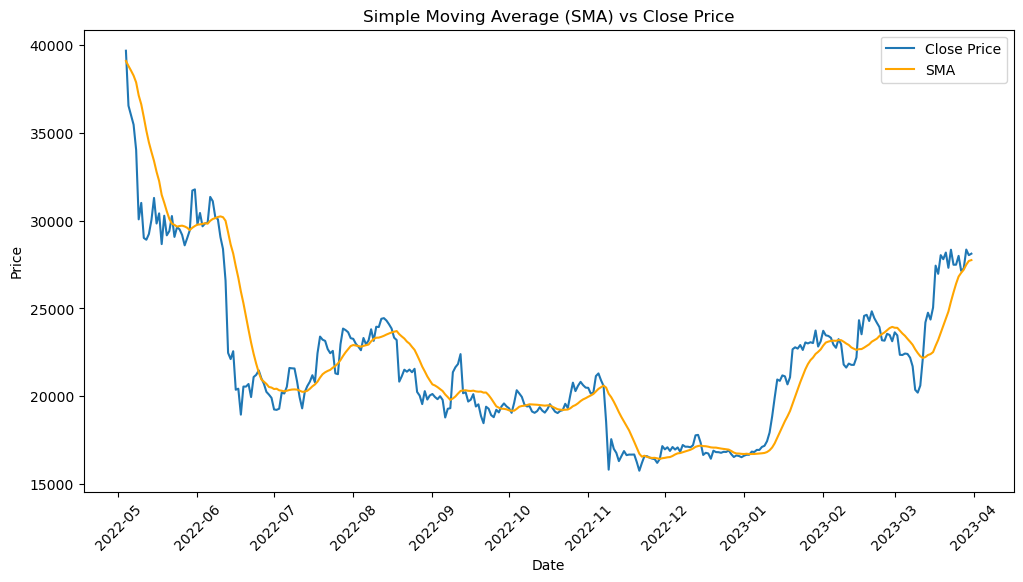

In [78]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['close'], label='Close Price')
plt.plot(df['time'], df['SMA'], label='SMA', color='orange')
plt.title('Simple Moving Average (SMA) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

The SMA is an average of the closing prices over a specified period. It helps investors identify trends by smoothing out the price data, making it easier to spot overall price direction. A rising SMA indicates an uptrend, while a falling SMA suggests a downtrend.

##### Exponential Moving Average (EMA)

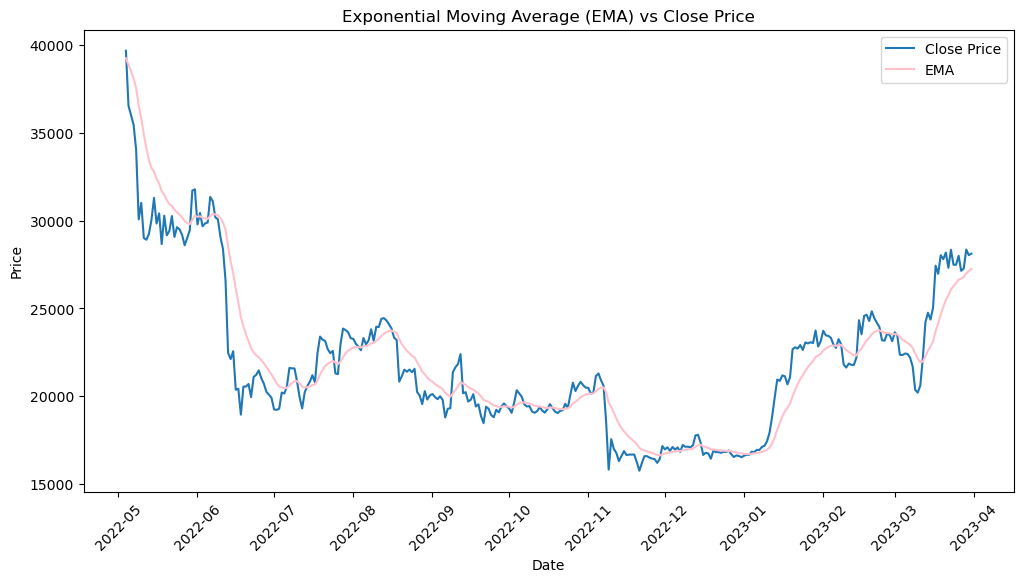

In [84]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['close'], label='Close Price')
plt.plot(df['time'], df['EMA'], label='EMA', color = 'pink')
plt.title('Exponential Moving Average (EMA) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

Similar to the SMA, the EMA also calculates an average of closing prices over a specified period. However, it gives more weight to recent prices, making it more responsive to new information. This responsiveness can help investors identify trend reversals more quickly.

##### Relative Strength Index (RSI)

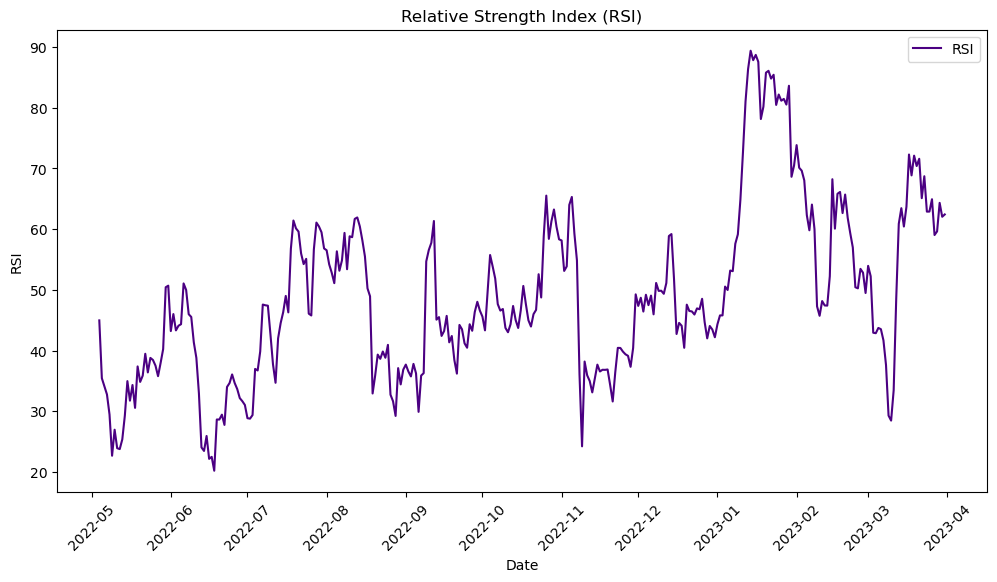

In [85]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['RSI'], label='RSI', color = 'indigo')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

RSI is a momentum oscillator that measures the speed and change of price movements. It can help investors identify overbought and oversold conditions, providing potential entry and exit points for trades.

##### Moving Average Convergence Divergence (MACD)

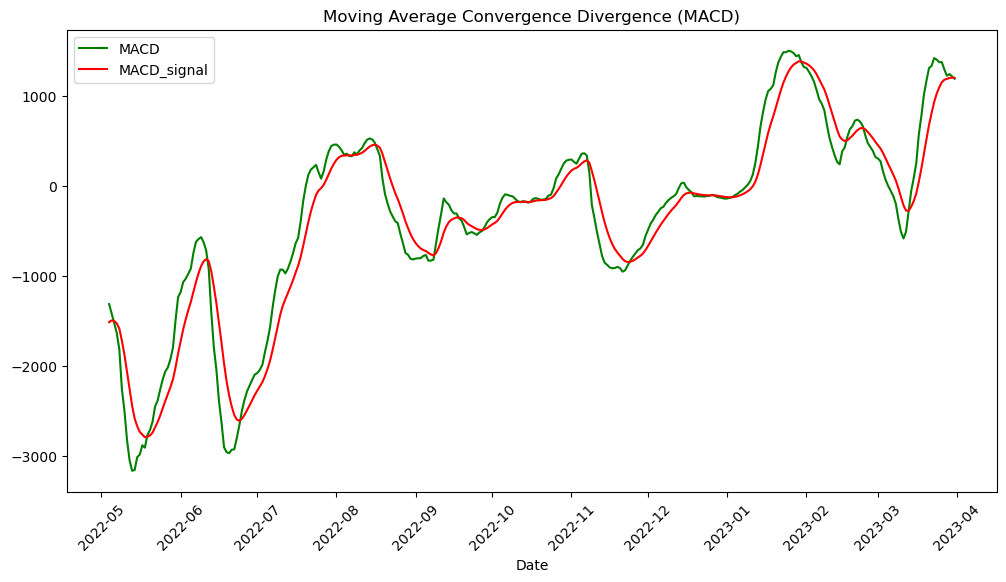

In [83]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['MACD'], label='MACD', color = 'g')
plt.plot(df['time'], df['MACD_signal'], label='MACD_signal', color = 'r')
plt.title('Moving Average Convergence Divergence (MACD)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. It can signal potential trend reversals and provide insight into the strength of a trend.

##### Bollinger Bands

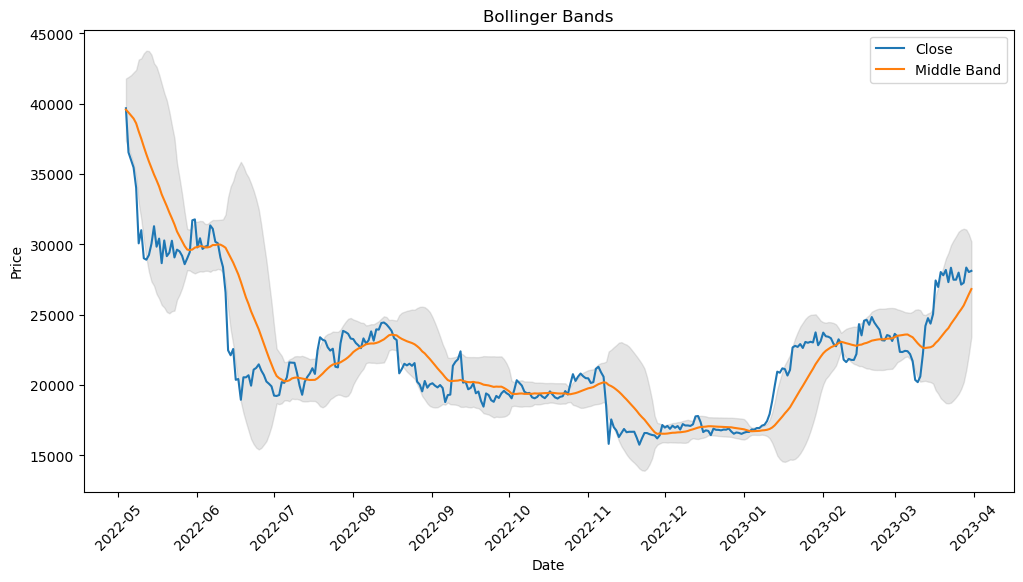

In [82]:
plt.figure(figsize=(12,6))

# Plot the close price
plt.plot(df['time'], df['close'], label='Close')

# Plot the Bollinger Bands ribbon
plt.fill_between(df['time'], df['BB_lower'], df['BB_upper'], alpha=0.2, color='grey')

# Plot the middle band as a line
plt.plot(df['time'], df['BB_middle'], label='Middle Band')

# Set the title and legend
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

Bollinger Bands are a volatility indicator that consists of a middle band (SMA) and two outer bands, which are standard deviations away from the middle band. The bands expand and contract based on price volatility, helping investors identify potential overbought and oversold conditions.

##### Average True Range (ATR)

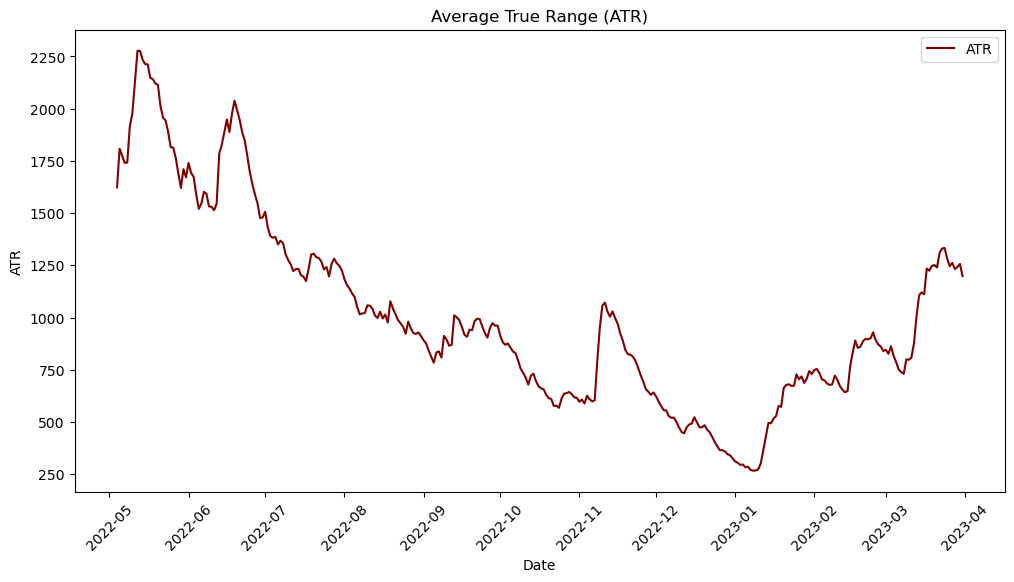

In [86]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['ATR'], label='ATR', color = 'maroon')
plt.title('Average True Range (ATR)')
plt.xlabel('Date')
plt.ylabel('ATR')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

ATR is a volatility indicator that measures the degree of price movement within a specified period. It can help investors determine the appropriate stop-loss and take-profit levels, as well as assess the risk associated with a particular trade.

##### Stochastic Oscillator (%K and %D)

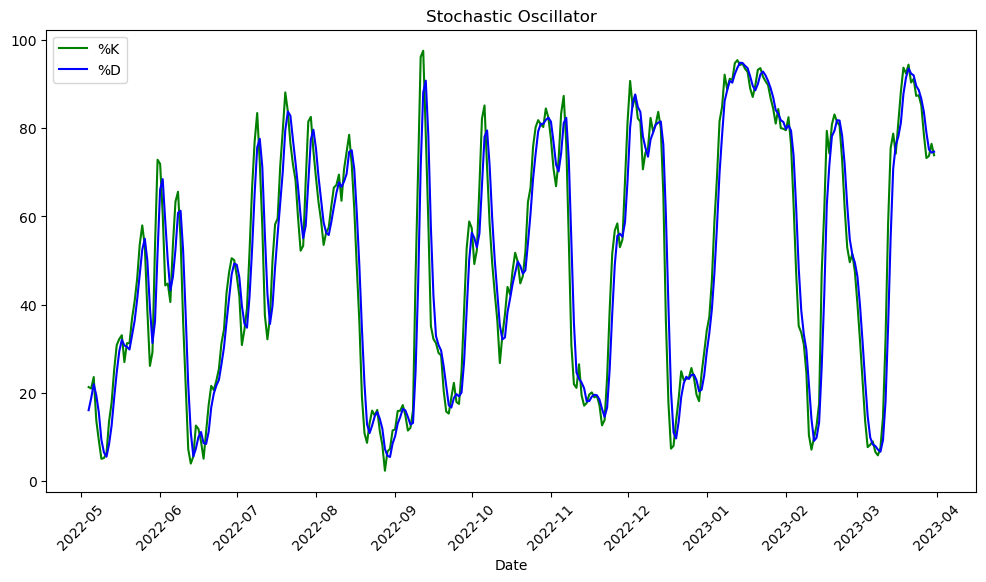

In [87]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['%K'], label='%K', color = 'g')
plt.plot(df['time'], df['%D'], label='%D', color = 'b')
plt.title('Stochastic Oscillator')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

The Stochastic Oscillator is a momentum indicator that compares a security's closing price to its price range over a specified period. It helps investors identify potential trend reversals and overbought or oversold conditions.

##### Commodity Channel Index (CCI)

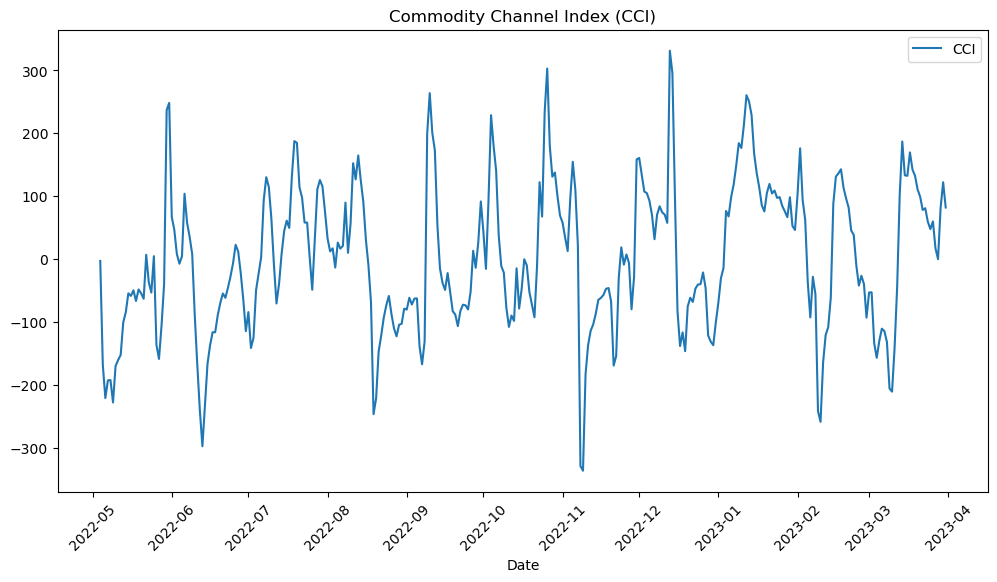

In [88]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['CCI'], label='CCI')
plt.title('Commodity Channel Index (CCI)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

CCI is a momentum oscillator that measures the deviation of a security's price from its statistical mean. It can help investors identify potential price reversals and overbought or oversold conditions.

##### On Balance Volume (OBV)

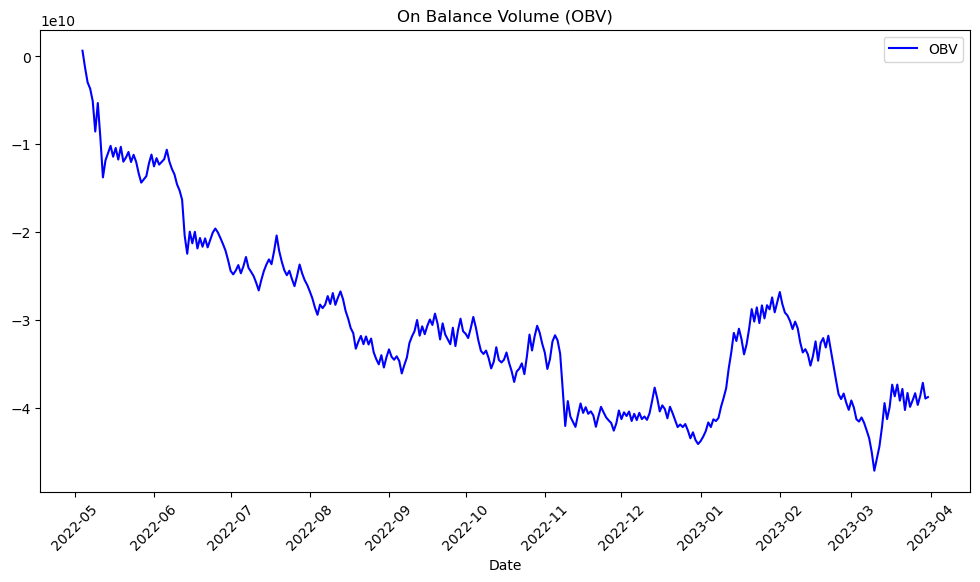

In [89]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['OBV'], label='OBV', color = 'b')
plt.title('On Balance Volume (OBV)')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

OBV is a volume-based indicator that measures buying and selling pressure. It can help investors confirm price trends and identify potential trend reversals based on changes in volume.

##### Rate of Change (ROC)

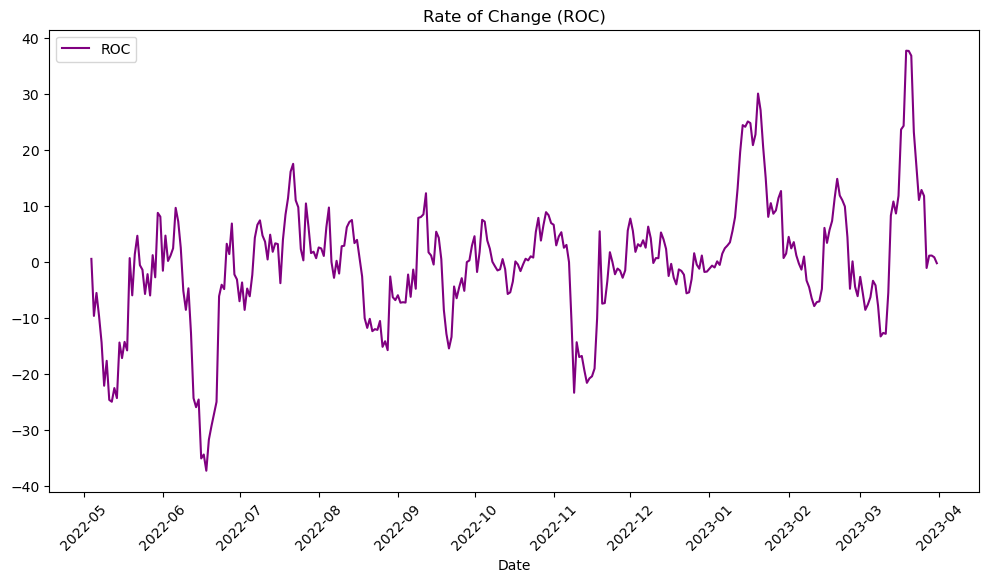

In [90]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['ROC'], label='ROC', color = 'purple')
plt.legend()
plt.title('Rate of Change (ROC)')
plt.xlabel('Date')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

ROC is a momentum oscillator that measures the percentage change in price over a specified period. It can help investors identify potential trend reversals and gauge the strength of a trend.

##### Parabolic Stop and Reverse (PSAR)

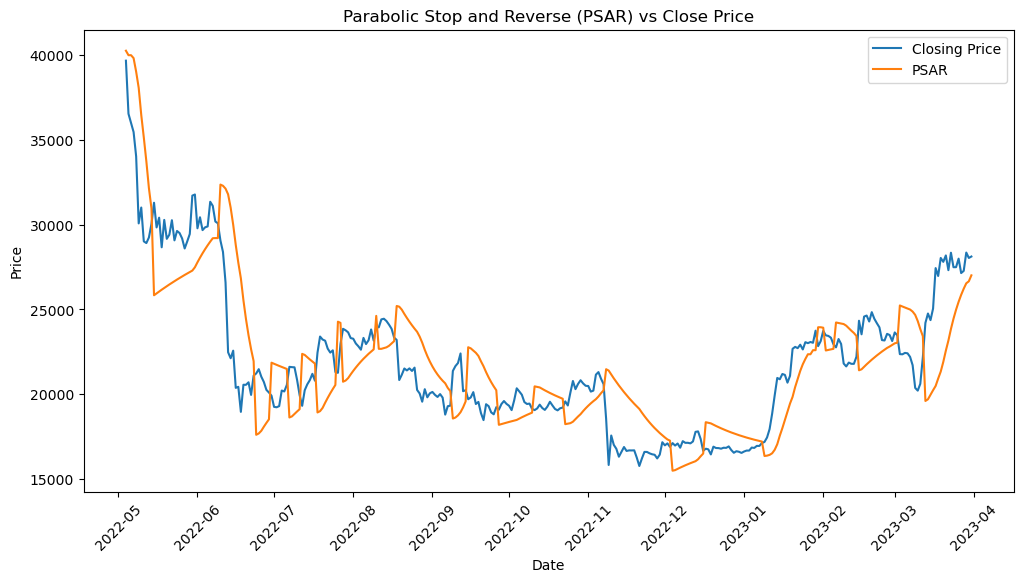

In [91]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['close'], label='Closing Price')
plt.plot(df['time'], df['PSAR'], label='PSAR')
plt.legend()
plt.title('Parabolic Stop and Reverse (PSAR) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

PSAR is a trend-following indicator that provides potential entry and exit points for trades. It helps investors determine the direction of a trend and can also be used as a trailing stop loss.

##### Volume Weighted Average Price (VWAP)

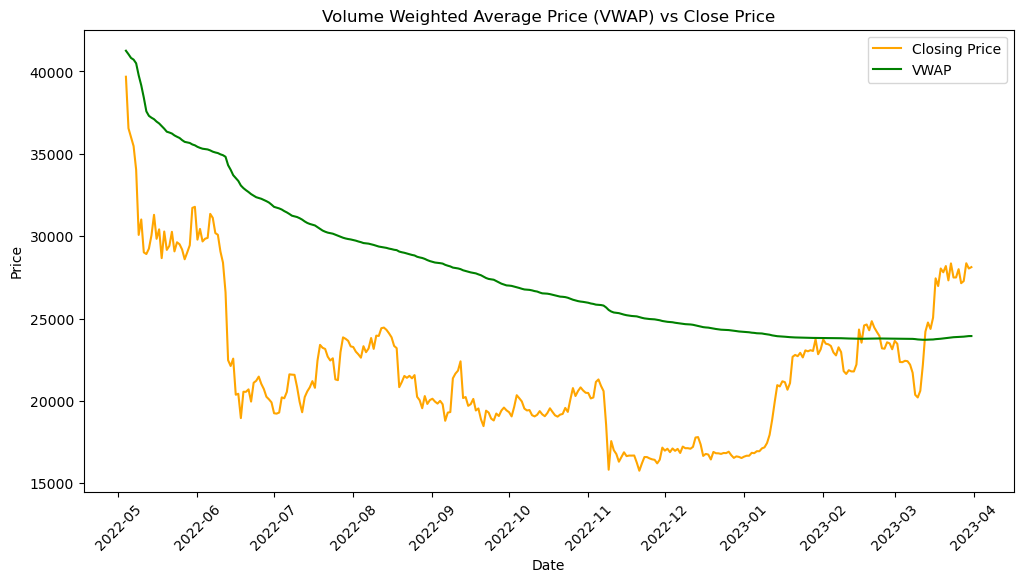

In [92]:
plt.figure(figsize=(12,6), )
plt.plot(df['time'], df['close'], label='Closing Price', color = 'orange')
plt.plot(df['time'], df['VWAP'], label='VWAP', color = 'g')
plt.legend()
plt.title('Volume Weighted Average Price (VWAP) vs Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

VWAP is the average price of a security, weighted by volume. It provides a benchmark for investors to assess the quality of their trade execution and can also be used as a support and resistance level for intraday trading.

## Splitting the Data

##### We now split the data into the X,y train/test.

In [19]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [20]:
def create_sequences(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df.iloc[i - window_size:i].values)
        y.append(df.iloc[i, 0])  # Assuming the target variable is the 'close' price
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [21]:
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))
print('\n')
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)
print("X_test dtype:", X_test.dtype)
print("y_test dtype:", y_test.dtype)

Length of train_data: 249
Length of test_data: 83


X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


## Stacked LSTM Neural Network Model

The model below consists of three LSTM layers stacked on top of each other, with dropout layers in between to help prevent overfitting. Here's a brief explanation of each layer in the model:

1. First LSTM layer (LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))): This layer has 50 LSTM units and is set to return sequences because the next layer is also an LSTM layer. It takes the input shape from the training data.
2. First dropout layer (Dropout(0.2)): This layer applies a dropout rate of 20% to the first LSTM layer's output, randomly setting some of the activations to zero during training to reduce overfitting.
3. Second LSTM layer (LSTM(units=50, return_sequences=True)): This layer has 50 LSTM units and also returns sequences because the next layer is another LSTM layer.
4. Second dropout layer (Dropout(0.2)): This layer applies a dropout rate of 20% to the second LSTM layer's output.
5. Third LSTM layer (LSTM(units=50)): This layer has 50 LSTM units and does not return sequences since the next layer is a Dense layer.
6. Third dropout layer (Dropout(0.2)): This layer applies a dropout rate of 20% to the third LSTM layer's output.
7. Dense output layer (Dense(units=1)): This layer produces the final output of the model, with a single output unit for the predicted value.

The model is compiled using the Adam optimizer with a learning rate of 0.001 and mean squared error as the loss function. The model is then trained for 50 epochs with a batch size of 32 using both training and validation data.

##### Developing the model

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

##### Evaluating the Model's Performance

In [23]:
train_loss = np.mean(model.evaluate(X_train, y_train, verbose=0))
test_loss = np.mean(model.evaluate(X_test, y_test, verbose=0))
print(f'Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}')

Train Loss: 0.00100, Test Loss: 0.09693


In [24]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [25]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train = np.zeros_like(X_train)
dummy_test = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the reshaped predicted values
dummy_train[:, :, 0] = y_train_pred
dummy_test[:, :, 0] = y_test_pred

# Perform the inverse transformation on the dummy arrays
y_train_pred_unscaled = scaler.inverse_transform(dummy_train[:, 0, :])[:, 0]
y_test_pred_unscaled = scaler.inverse_transform(dummy_test[:, 0, :])[:, 0]

In [26]:
# Create dummy arrays of zeros with the same shape as X_train and X_test
dummy_train_y = np.zeros_like(X_train)
dummy_test_y = np.zeros_like(X_test)

# Replace the first column of the dummy arrays with the actual y values
dummy_train_y[:, :, 0] = y_train.reshape(-1, 1)
dummy_test_y[:, :, 0] = y_test.reshape(-1, 1)

# Perform the inverse transformation on the dummy arrays
y_train_unscaled = scaler.inverse_transform(dummy_train_y[:, 0, :])[:, 0]
y_test_unscaled = scaler.inverse_transform(dummy_test_y[:, 0, :])[:, 0]

In [27]:
train_rmse = np.sqrt(mean_squared_error(y_train_unscaled, y_train_pred_unscaled))
test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
print(f'Train RMSE: {train_rmse:.5f}, Test RMSE: {test_rmse:.5f}')

Train RMSE: 755.39255, Test RMSE: 7447.31304


##### Visualizing the results.

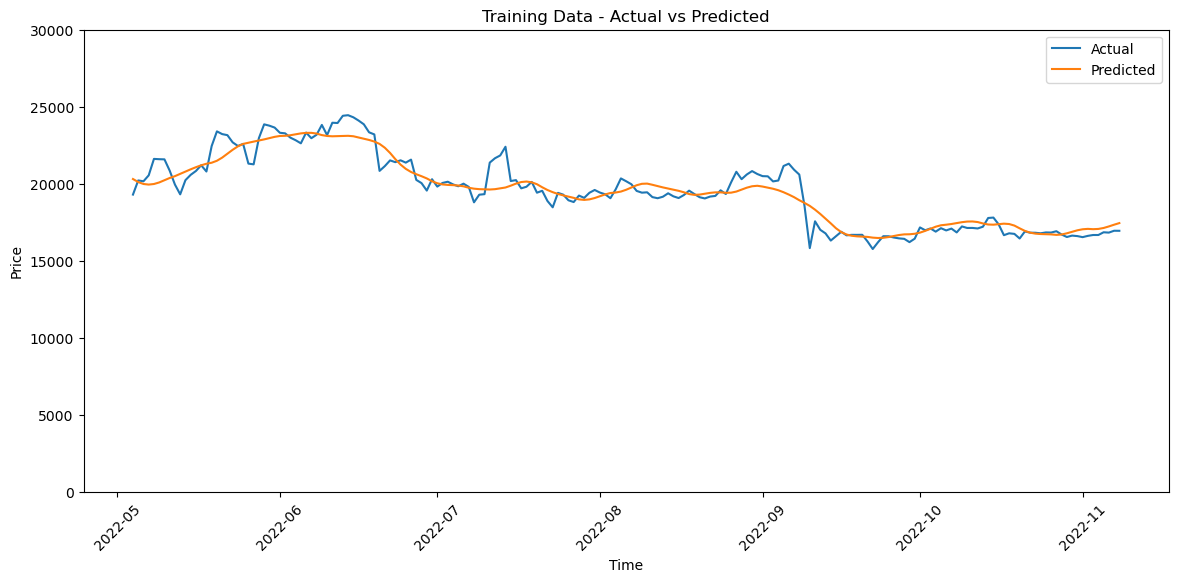

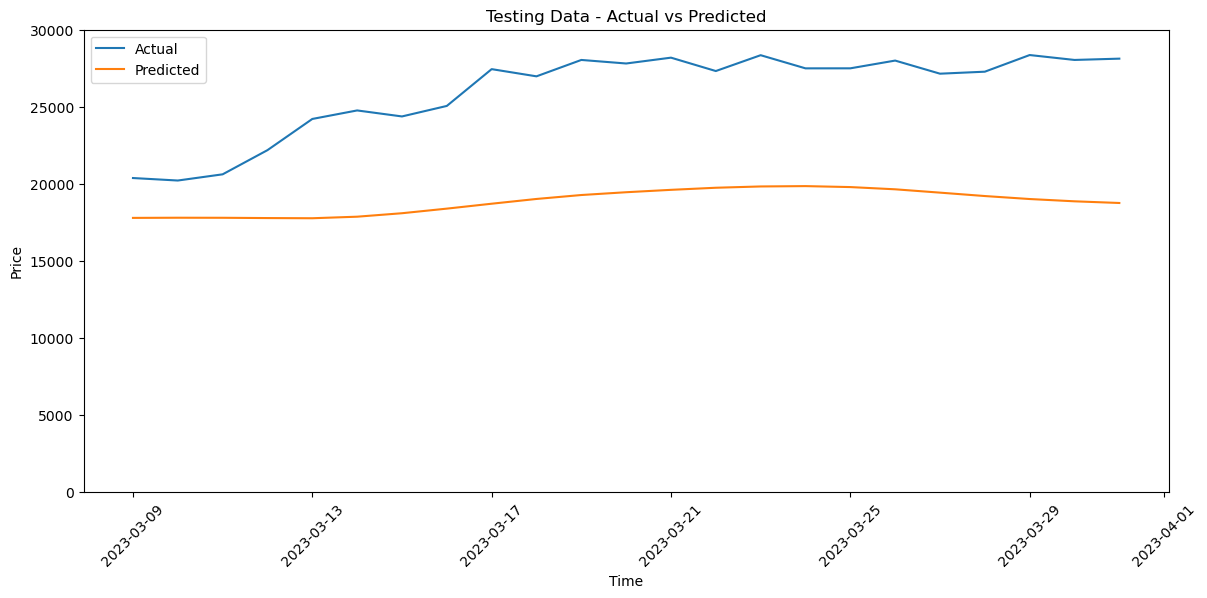

In [94]:
# For training data
train_time = df['time'][:len(y_train_unscaled)]

plt.figure(figsize=(14, 6))
plt.plot(train_time, y_train_unscaled, label='Actual')
plt.plot(train_time, y_train_pred_unscaled, label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.ylim(0, 30000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# For testing data
test_time = df['time'][len(df) - len(y_test_unscaled):]

plt.figure(figsize=(14, 6))
plt.plot(test_time, y_test_unscaled, label='Actual')
plt.plot(test_time, y_test_pred_unscaled, label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.ylim(0, 30000)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
train_mape = mean_absolute_percentage_error(y_train_unscaled, y_train_pred_unscaled)
test_mape = mean_absolute_percentage_error(y_test_unscaled, y_test_pred_unscaled)

print(f'Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%')

Train MAPE: 2.74%, Test MAPE: 26.91%


The model was evaluated using a Mean Absolute Percentage Error (MAPE) metric, which measures the average percentage difference between the predicted and actual values. The test MAPE for this particular model was found to be 26.91%, indicating that the model's predictions were, on average, off by around 27% from the actual Bitcoin prices. While this level of accuracy may not be ideal for some applications, it can still be useful for providing a general sense of the market trends and identifying potential trading opportunities.

## 5-Fold Cross Validation

In 5-fold cross validation, the dataset is divided into 5 equal parts or "folds". The model is trained on 4 folds, using them as the training set, and the remaining fold is used as the validation set. This process is repeated 5 times, with each fold being used as the validation set once. The model's performance is averaged over the 5 validation sets to obtain a single performance metric. This method helps assess the model's ability to generalize to unseen data.

##### Strengths:
- Provides a more robust estimate of model performance than a single train-test split.
- Reduces the risk of overfitting by averaging performance over multiple validation sets.
- Provides a good indication of how well the model will perform on new, unseen data.

##### Limitations:
- May not be suitable for time series data with strong temporal dependencies, as shuffling the data may lead to leakage of information from the future into the training set.
- Can be computationally expensive, especially for large datasets or complex models, as the model has to be trained multiple times.

5-fold cross validation may provide a more robust estimate of model performance, but it may not work well with the temporal structure of the data. 

##### Developing the model

This code defines a function create_lstm_model(input_shape) that creates a stacked LSTM model with three LSTM layers and dropout layers in between. The function returns the compiled model with Adam optimizer and mean squared error as the loss function. The second function, lstm_5fold_cross_validation(X, y, n_splits=5, scaler=None), performs time series cross-validation with a default of 5 folds on the provided data. It trains an LSTM model for each fold, records predictions and true values, and calculates the root mean squared error (RMSE) and mean absolute percentage error (MAPE) for each fold. The function returns lists of RMSE and MAPE values, along with the predictions and true values.

In [38]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def lstm_5fold_cross_validation(X, y, n_splits=5, scaler=None):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_values, mape_values, accuracy_values = [], [], []
    predictions, true_values = [], []  # Add lists to store predictions and true_values

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create and train the model
        model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

        # Make predictions
        y_test_pred = model.predict(X_test)

        # Unscale the predictions and true values
        y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
        y_test_reshaped = y_test.reshape(-1, 1)
        dummy_test = np.zeros((y_test_pred_reshaped.shape[0], X_test.shape[2] - 1))

        y_test_pred_unscaled = scaler.inverse_transform(np.hstack((y_test_pred_reshaped, dummy_test)))[:, 0]
        y_test_unscaled = scaler.inverse_transform(np.hstack((y_test_reshaped, dummy_test)))[:, 0]

        predictions.append(y_test_pred _unscaled)  # Append unscaled predictions
        true_values.append(y_test_unscaled)  # Append unscaled true_values

        # Calculate the RMSE
        rmse = sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
        rmse_values.append(rmse)

        # Calculate the MAPE
        mape = np.mean(np.abs((y_test_unscaled - y_test_pred_unscaled) / y_test_unscaled)) * 100
        mape_values.append(mape)

    return rmse_values, mape_values, predictions, true_values  # Return predictions and true_values

# Prepare the data using the create_sequences function
window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Call the lstm_cross_validation function
rmse_5f_values, mape_5f_values, predictions_5f, true_values_5f = lstm_5fold_cross_validation(X, y, n_splits=5, scaler=scaler)

2/2 [==============================] - 1s 30ms/step


##### Visualizing the results

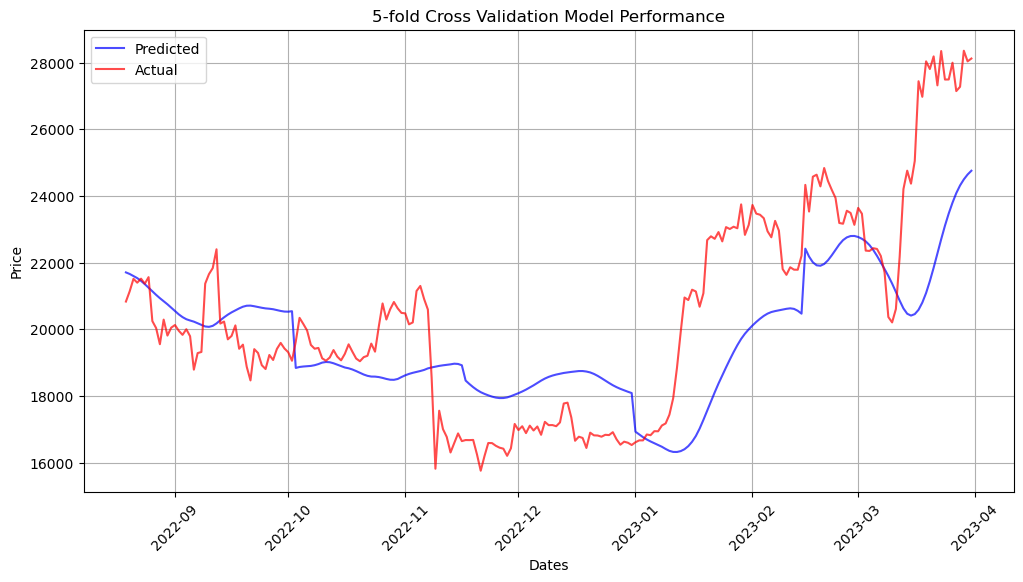

RMSE: 2124.79850
Average MAPE: 8.57%


In [69]:
mean_5f_rmse = np.mean(rmse_5f_values)
mean_5f_mape = np.mean(mape_5f_values)

def plot_cross_validation_results(predictions, true_values, mean_rmse, mean_mape, df, window_size):
    plt.figure(figsize=(12, 6))
    
    # Concatenate the predictions and true values lists
    unscaled_predictions = np.concatenate(predictions)
    unscaled_true_values = np.concatenate(true_values)

    # Calculate the starting point for the x-axis
    starting_point = len(df) - len(unscaled_true_values)
    
    # Calculate the correct length for the x-axis array
    x_axis_length = len(df) - starting_point

    # Create a new x-axis array with actual dates from the 'time' column
    x_axis = df['time'][starting_point:starting_point + x_axis_length]
    
    # Plot the results using the new x-axis array
    plt.plot(x_axis, unscaled_predictions, label='Predicted', color='blue', alpha=0.7)
    plt.plot(x_axis, unscaled_true_values, label='Actual', color='red', alpha=0.7)
    plt.title('5-fold Cross Validation Model Performance')
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

    print(f"RMSE: {mean_rmse:.5f}")
    print(f"Average MAPE: {mean_mape:.2f}%")

plot_cross_validation_results(predictions_5f, true_values_5f, mean_5f_rmse, mean_5f_mape, df, window_size)

The MAPE has been reduced by approximately 18.34%, which highlights the effectiveness of employing cross-validation techniques on regression models. A MAPE of 8.57% after cross-validation signifies that the LSTM model's predictions deviate from the actual values by an average of 8.57%. This relatively low error rate implies that the LSTM model is proficient at capturing the underlying dynamics of the time series data.

The improved accuracy can offer valuable insights for investors, enabling them to make more informed decisions and better manage risk in the financial markets. By utilizing a cross-validated LSTM model, investors can gain a deeper understanding of the factors influencing price movements and identify potential trends or market anomalies. Consequently, this enhanced predictive capability can lead to more strategic investment planning and potentially higher returns.

However, it is crucial to recognize that the model's performance is not flawless, and the inherent uncertainty in financial markets remains. The 8.57% error rate, while relatively low, indicates that predictions should be treated with caution and not solely relied upon for decision-making. Combining the model's insights with other market indicators and fundamental analysis can help investors create a more comprehensive and balanced investment strategy.

## Rolling Origin Cross Validation

Rolling origin cross validation, also known as time series cross validation, is specifically designed for time series data. In this method, the dataset is split into a training and validation set, with the validation set starting at a certain point in time. The model is trained on the initial training set and validated on the validation set. The process is then repeated by rolling the starting point of the validation set forward in time, expanding the training set to include the previous validation set, and using a new validation set. This ensures that the training set always precedes the validation set in time, preserving the temporal structure of the data.

##### Strengths:
- Preserves the temporal structure of the data, making it suitable for time series forecasting.
- Provides a realistic estimate of the model's performance on new, unseen data by validating on data points that come after the training data.
- Reduces the risk of data leakage due to shuffling the dataset.

##### Limitations:
- Can be computationally expensive, as the model needs to be retrained multiple times.
- May not work well for datasets with strong seasonality or recurring patterns, as the model may not be exposed to the full range of these patterns during training.

Rolling origin cross validation preserves the temporal structure, making it more suitable for time series forecasting but may not capture seasonal patterns effectively. Additionally, the predictions from this model will only capture the last 50 data points because of it's limitations.

##### Developing the model

This code is very similar to the 5-fold cross validation, but has a slightly different cross-validation approach. The create_lstm_model(input_shape) function is the same as in the first approach. The second function, lstm_cross_validation(X, y, test_size, scaler=None), performs a rolling origin cross-validation on the provided data with a specified test size. It trains an LSTM model for each step in the rolling window, records predictions and true values, and calculates the root mean squared error (RMSE) and mean absolute percentage error (MAPE) for each step. The function returns lists of RMSE and MAPE values, along with the predictions and true values.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def lstm_cross_validation(X, y, test_size, scaler=None):
    rmse_values, mape_values, predictions, true_values = [], [], [], []

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    train_size = X.shape[0] - test_size
    for i in range(train_size, X.shape[0]):
        X_train, X_test = X[:i], X[i:i+1]
        y_train, y_test = y[:i], y[i:i+1]

        # Create and train the model
        model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

        # Make predictions
        y_test_pred = model.predict(X_test)

        # Unscale the predictions and true values
        y_test_pred_reshaped = y_test_pred.reshape(-1, 1)
        y_test_reshaped = y_test.reshape(-1, 1)
        dummy_test = np.zeros((y_test_pred_reshaped.shape[0], X_test.shape[2] - 1))

        y_test_pred_unscaled = scaler.inverse_transform(np.hstack((y_test_pred_reshaped, dummy_test)))[:, 0]
        y_test_unscaled = scaler.inverse_transform(np.hstack((y_test_reshaped, dummy_test)))[:, 0]

        predictions.append(y_test_pred_unscaled)
        true_values.append(y_test_unscaled)

        # Calculate the RMSE
        rmse = sqrt(mean_squared_error(y_test_unscaled, y_test_pred_unscaled))
        rmse_values.append(rmse)

        # Calculate the MAPE
        mape = np.mean(np.abs((y_test_unscaled - y_test_pred_unscaled) / y_test_unscaled)) * 100
        mape_values.append(mape)

    return rmse_values, mape_values, predictions, true_values

# Prepare the data using the create_sequences function
window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Determine the test size (e.g., 20% of the dataset)
test_size = int(len(X) * 0.2)

# Call the lstm_cross_validation function
rmse_values, mape_values, predictions, true_values = lstm_cross_validation(X, y, test_size, scaler=scaler)

##### Visualizing the results

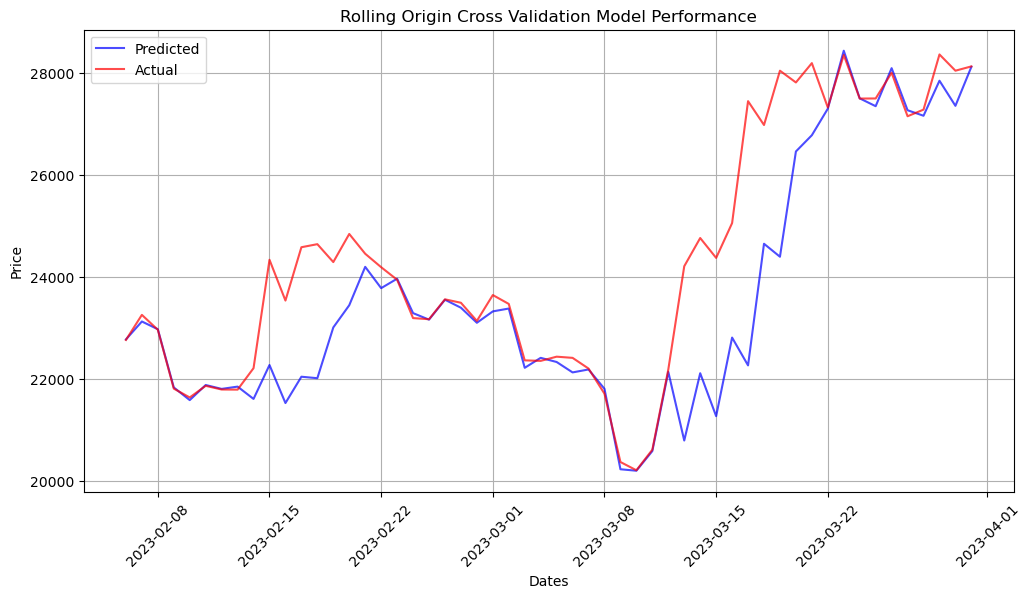

RMSE: 782.05216
Average MAPE: 3.08%


In [71]:
def plot_rolling_origin_results(predictions, true_values, mean_rmse, mean_mape, df, start_index):
    plt.figure(figsize=(12, 6))
    
    # Concatenate the predictions and true values lists
    unscaled_predictions = np.concatenate(predictions)
    unscaled_true_values = np.concatenate(true_values)
    
    # Create a new x-axis array with actual dates from the 'time' column
    x_axis = df['time'][start_index:start_index + len(unscaled_predictions)]
    
    plt.plot(x_axis, unscaled_predictions, label='Predicted', color='blue', alpha=0.7)
    plt.plot(x_axis, unscaled_true_values, label='Actual', color='red', alpha=0.7)
    plt.title('Rolling Origin Cross Validation Model Performance')
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

    print(f"RMSE: {mean_rmse:.5f}")
    print(f"Average MAPE: {mean_mape:.2f}%")

start_index = window_size + len(X) - len(predictions[0]) * len(predictions)
plot_rolling_origin_results(predictions, true_values, mean_rmse, mean_mape, df, start_index)

The MAPE has been significantly reduced to 3.08% after implementing the rolling origin cross-validation technique, which emphasizes the effectiveness of this method in refining regression models. A MAPE of 3.08% signifies that the LSTM model's predictions deviate from the actual values by an average of only 3.08%. This remarkably low error rate indicates that the LSTM model is highly adept at capturing the underlying dynamics of the time series data.

The enhanced accuracy can provide valuable insights for investors, allowing them to make more informed decisions and manage risk more effectively in the financial markets. By using a rolling origin cross-validated LSTM model, investors can gain a more profound understanding of the factors driving price movements and identify potential trends or market anomalies. As a result, this improved predictive capability can contribute to more strategic investment planning and potentially higher returns.

It is essential, however, to recognize that the model's performance is not perfect, and the inherent uncertainty in financial markets still prevails. The 3.08% error rate, while impressively low, suggests that predictions should be approached with prudence and not solely relied upon for decision-making. Integrating the model's insights with other market indicators and fundamental analysis can help investors develop a more comprehensive and well-rounded investment strategy, further mitigating potential risks.